# Visualizing Offensive language keywords  - Word2Vec and t-SNE

March 22, 2021

Code is adapted from [Google News and Leo Tolstoy: Visualizing Word2Vec Word Embeddings using t-SNE](https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d) by Sergey Smetanin.

We use Google's Word2Vec vectors from [https://code.google.com/archive/p/word2vec/](https://code.google.com/archive/p/word2vec/).

> We are publishing pre-trained vectors trained on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described by Mikolov et al., 2013.
>
> Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean. Distributed Representations of Words and Phrases and their Compositionality. In Proceedings of NIPS, 2013.

### Imports

In [1]:
import gensim
import gensim.downloader
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import numpy as np
import tempfile
import imageio
import shutil
import os
from statistics import mean
import pandas as pd 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from gensim.test.utils import datapath
from gensim.models.fasttext import load_facebook_vectors

from IPython.display import Image
from IPython.display import display
pd.options.display.max_columns = None

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

### Constants

In [2]:
TOP_N = 30
KEYS = { \
    "offensive": set(), 
    "abusive": set(), 
    "cyberbullying": set(), 
    "vulgar": set(), 
    "racist": set(), 
    "homophobic": set(), 
    "profane": set(), 
    "slur": set(), 
    "harrasment": set(), 
    "obscene": set(), 
    "threat": set(), 
    "discredit": set(), 
    "hateful": set(), 
    "insult": set(), 
    "hostile": set(),
    "taboo": set()
}
FIXED_KEYS = list(KEYS.keys())

Too similar words that will not be taken into account as neighbouring words:

In [3]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'offensive': {'offens', 'offensive'},
 'abusive': {'abus', 'abusive'},
 'cyberbullying': {'cyberbulli', 'cyberbullying'},
 'vulgar': {'vulgar'},
 'racist': {'racist'},
 'homophobic': {'homophob', 'homophobic'},
 'profane': {'profan', 'profane'},
 'slur': {'slur'},
 'harrasment': {'harras', 'harrasment'},
 'obscene': {'obscen', 'obscene'},
 'threat': {'threat'},
 'discredit': {'discredit'},
 'hateful': {'hate', 'hateful'},
 'insult': {'insult'},
 'hostile': {'hostil', 'hostile'},
 'taboo': {'taboo'}}

### Functions

In [4]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [5]:
def getSimilarWords(model_gn):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in model_gn.most_similar(key, topn=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [6]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)

In [7]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        #plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
        #    textcoords='offset points', ha='center', va='center', size=15)
        
        plt.text(x.mean(), y.mean(), label.upper(), color='white', weight='bold', fontsize=13, 
                 path_effects=[PathEffects.withStroke(linewidth=3, foreground="black", alpha=0.9)])
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [8]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [9]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [10]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

## Word2Vec

Loading model

In [11]:
model_gn = gensim.downloader.load('word2vec-google-news-300')

In [12]:
print(f"Vocabulary size: {len(model_gn.vocab)}")

Vocabulary size: 3000000


Getting similar words. Printed out words are neighboring words that are ommited for the analysis.

In [13]:
word_clusters, embedding_clusters = getSimilarWords(model_gn)

{'offensive', 'offens'} -- offensive
{'offensive', 'offens'} -- offensively
{'offensive', 'offens'} -- offense
{'offensive', 'offens'} -- offensively
{'offensive', 'offens'} -- offensive line
{'offensive', 'offens'} -- offensive firepower
{'abusive', 'abus'} -- abusive
{'abusive', 'abus'} -- verbally abusive
{'abusive', 'abus'} -- abuse
{'abusive', 'abus'} -- verbal abuse
{'abusive', 'abus'} -- abused
{'abusive', 'abus'} -- physically abused
{'abusive', 'abus'} -- abuser
{'abusive', 'abus'} -- abusive neglectful
{'abusive', 'abus'} -- verbal abuse
{'abusive', 'abus'} -- profane abusive
{'abusive', 'abus'} -- sexually abusive
{'abusive', 'abus'} -- verbally abused
{'abusive', 'abus'} -- abusing
{'abusive', 'abus'} -- sexually abused
{'abusive', 'abus'} -- abusive profane
{'abusive', 'abus'} -- verbally abusing
{'abusive', 'abus'} -- nonabusive
{'abusive', 'abus'} -- physically abusing
{'cyberbulli', 'cyberbullying'} -- cyberbullying
{'cyberbulli', 'cyberbullying'} -- cyberbullies
{'cybe

In [14]:
displayDF(word_clusters)

,offensive,abusive,cyberbullying,vulgar,racist,homophobic,profane,slur,harrasment,obscene,threat,discredit,hateful,insult,hostile,taboo
0,defensive,graphically_depicts_physically,cyber_bullying,profane,racism,racist,vulgar,derogatory,harassment,vulgar,danger,malign,bigoted,affront,unfriendly,touchy_subject
1,coach_Bob_Palcic,Luke_McNorton,sexting,obscene,anti_Semitic,gay_bashing,obscenities,racist_remark,Harassment,indecent,imminent_danger,besmirch,racist,disrespect,antagonistic,frowned_upon
2,guard_RJ_Mattes,Dorian_Wesson,bullying,crass,bigoted,antigay,vulgar_language,epithet,harassments,pornographic,menace,embarrass,vile,disrespectful,nipple_pinching,verboten
3,coach_Jimmy_Heggins,inappropriate,Cyber_bullying,rude,homophobic,transphobic,foul_language,derogatory_remark,harassement,lewd,challenge,delegitimize,hurtful,disgrace,warlike,stigma_attached
4,promoted_Pete_Metzelaars,adequate_Tamberg,cyberstalking,demeaning,hateful,gay,expletives,word_nigger,ASPEN_Colo._Actor,sexually_explicit,dangers,demonize,mean_spirited,denigrate,unwelcoming,forbidden
5,Dave_Borbely,rude,Bullying,politically_incorrect,anti_semitic,homosexual,curse_words,remark,Verbal_abuse,filthy_diatribe,hazard,smear,anti_semetic,demean,mistaken_celebratory_gunfire,touchy
6,coach_George_Yarno,Mo'Nique_searing,cyberbully,sexist,rascist,bigoted,hateful,racial_epithet,violance,inappropriate,nightmare_scenario,marginalize,bigotry,humiliate,confrontational,touchy_subjects
7,coach_Dave_Magazu,Advocate_Safehouse_Project,Cyber_Bullying,raunchy,racialist,anti_Semitic,foul_mouthed,derogatory_language,sexual_harassments,disgusting,possibility,vilify,vitriolic,dishonor,inhospitable,unmentionable
8,coach_Greg_Studrawa,behaves_unreasonably_yells,schoolyard_bullying,culturally_insensitive_inappropriate,racially_motivated,hateful,politically_incorrect,racist_connotations,verbal_abuse,outrageous,peril,denigrate,racist_sexist_homophobic,disrespecting,belligerent,Broaching
9,coach_Dan_Roushar,delete_inappropriate,cyber_bulling,obnoxious,sexist,anti_semitic,containing_advertising_astroturfing,racist,harassing,insulting,concern,belittle,hatred,belittle,neocolonialist_enemies,broach


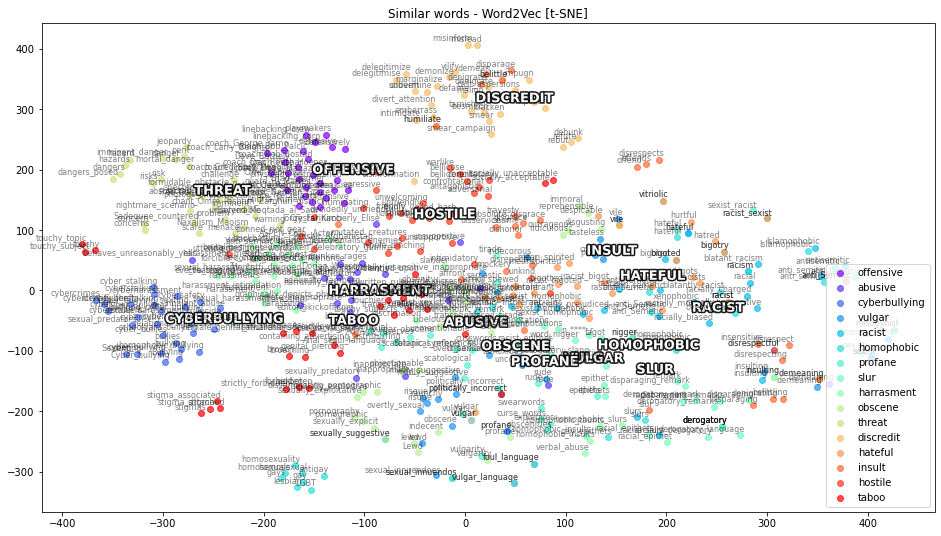

In [15]:
plotTSNE("Similar words - Word2Vec [t-SNE]", word_clusters, embedding_clusters, "SimilarWords - word2vec - t-SNE.png")

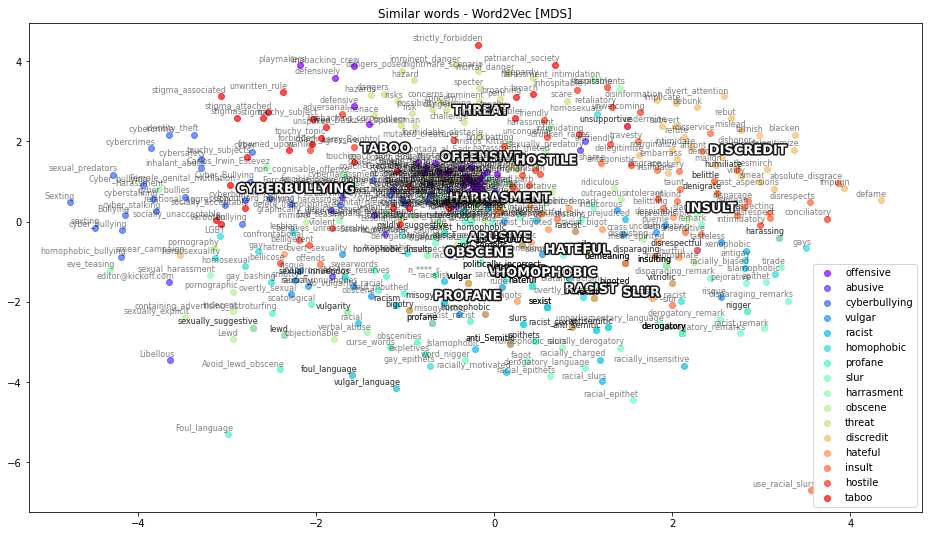

In [16]:
plotMDS("Similar words - Word2Vec [MDS]", word_clusters, embedding_clusters, "SimilarWords - word2vec - MDS.png")

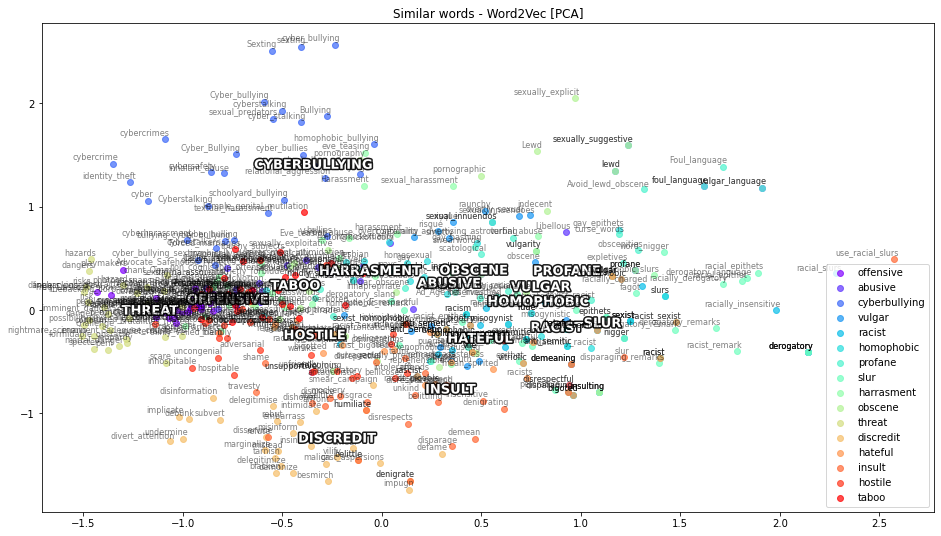

In [17]:
plotPCA("Similar words - Word2Vec [PCA]", word_clusters, embedding_clusters, "SimilarWords - word2vec - PCA.png")

## Glove

Loading model

In [18]:
model_gn = gensim.downloader.load('glove-wiki-gigaword-300')

In [19]:
print(f"Vocabulary size: {len(model_gn.vocab)}")

Vocabulary size: 400000


Getting similar words. Printed out words are neighboring words that are ommited for the analysis.

In [20]:
word_clusters, embedding_clusters = getSimilarWords(model_gn)

{'offensive', 'offens'} -- offense
{'offensive', 'offens'} -- offensives
{'offensive', 'offens'} -- offensively
{'abusive', 'abus'} -- abuse
{'abusive', 'abus'} -- abused
{'abusive', 'abus'} -- abusing
{'vulgar'} -- vulgarity
{'racist'} -- racists
{'homophobic', 'homophob'} -- homophobia
{'profan', 'profane'} -- profanity
{'slur'} -- slurs
{'harras', 'harrasment'} -- harrassment
{'obscene', 'obscen'} -- obscenity
{'obscene', 'obscen'} -- obscenities
{'threat'} -- threats
{'threat'} -- threatening
{'threat'} -- threatened
{'threat'} -- threaten
{'threat'} -- threatens
{'discredit'} -- discrediting
{'discredit'} -- discredited
{'hate', 'hateful'} -- hate
{'insult'} -- insulting
{'insult'} -- insults
{'insult'} -- insulted
{'hostile', 'hostil'} -- hostility
{'taboo'} -- taboos


In [21]:
displayDF(word_clusters)

,offensive,abusive,cyberbullying,vulgar,racist,homophobic,profane,slur,harrasment,obscene,threat,discredit,hateful,insult,hostile,taboo
0,defensive,neglectful,bullying,profane,homophobic,sexist,vulgar,derogatory,romish,indecent,danger,undermine,bigoted,affront,unfriendly,homosexuality
1,lineman,inappropriate,cyberstalking,obscene,sexist,racist,raunchy,homophobic,pi96,lewd,posed,embarrass,hurtful,disrespect,takeover,topic
2,linemen,sexually,cyber-bullying,raunchy,semitic,misogynistic,obscene,epithets,nonfeasance,vulgar,pose,intimidate,racist,offend,belligerent,sacrosanct
3,coordinator,stepfather,sexting,risque,xenophobic,slurs,vulgarity,disparaging,zety,profane,possibility,defame,vile,humiliation,antagonistic,forbidden
4,attack,behavior,anti-gay,crass,anti-semitic,misogynist,misogynistic,uttered,depressurisation,pornographic,warned,rebut,homophobic,shame,enemy,topics
5,quarterback,verbally,vigilantism,sexist,antisemitic,bigoted,ribald,racist,keyrates,inappropriate,warning,humiliate,sexist,provocation,takeovers,touchy
6,blitz,overbearing,victimisation,tasteless,slurs,antisemitic,irreverent,nigger,jiwamol,insulting,poses,tarnish,despicable,ridicule,threats,broached
7,forces,bullying,victimization,suggestive,racism,anti-semitic,scatological,epithet,demoralisation,defamatory,imminent,smear,intolerant,embarrassment,aggressive,incest
8,fighting,disrespectful,self-harm,derogatory,hateful,xenophobic,rude,sexist,supunnabul,gestures,dangers,destabilize,idiotic,disrespectful,fend,subject
9,tackle,domineering,harrassment,disrespectful,bigoted,semitic,bawdy,semitic,ryryryryryry,immoral,possible,portray,disgusting,injustice,enemies,unspoken


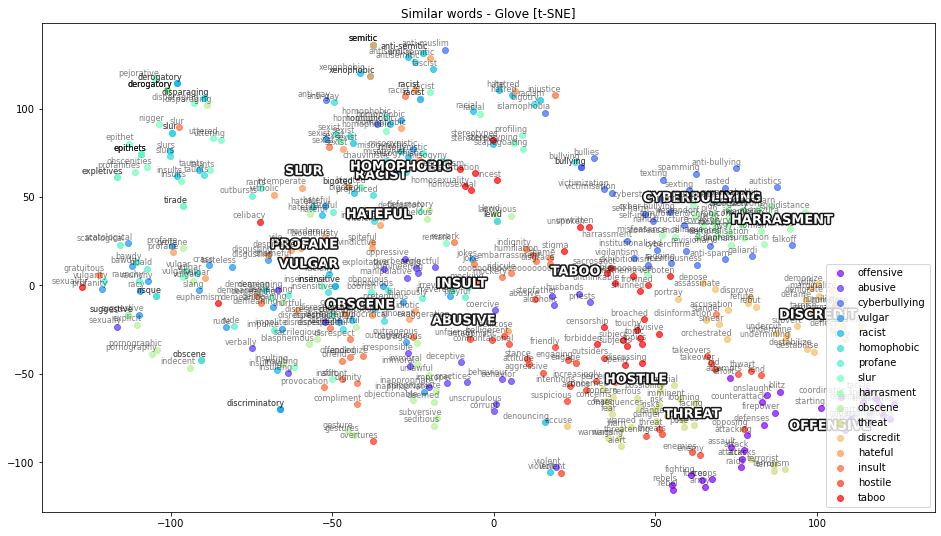

In [22]:
plotTSNE("Similar words - Glove [t-SNE]", word_clusters, embedding_clusters, "SimilarWords - Glove - t-SNE.png")

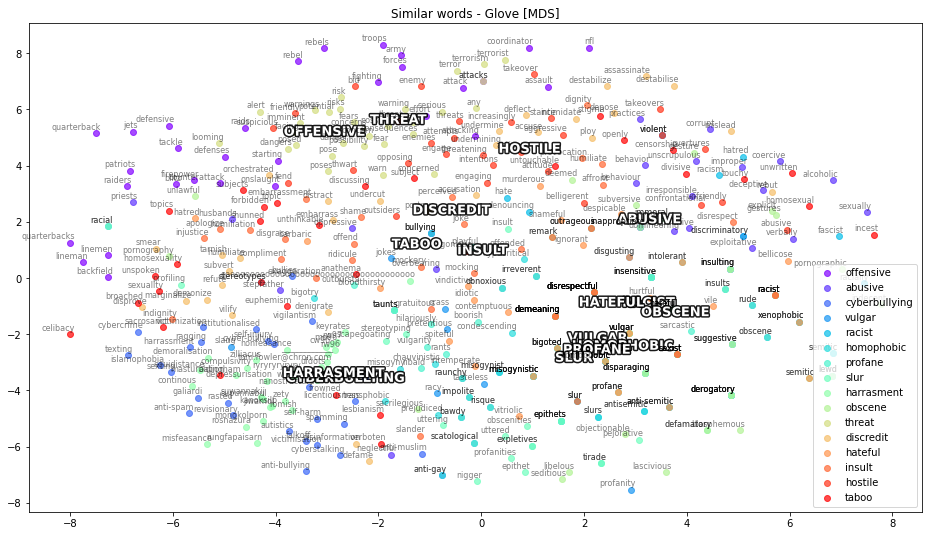

In [23]:
plotMDS("Similar words - Glove [MDS]", word_clusters, embedding_clusters, "SimilarWords - Glove - MDS.png")

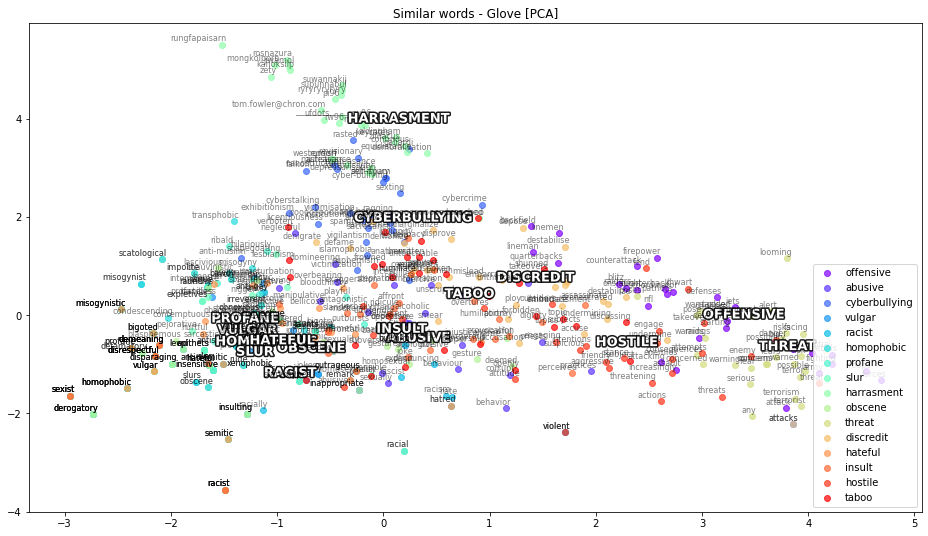

In [24]:
plotPCA("Similar words - Glove [PCA]", word_clusters, embedding_clusters, "SimilarWords - Glove - PCA.png")

## fastText

Loading model

In [25]:
# Run first time only to download model
#import fasttext.util
#fasttext.util.download_model('en', if_exists='ignore')  # English
#ft = fasttext.load_model('cc.en.300.bin')

# Chaya used: https://fasttext.cc/docs/en/crawl-vectors.html
# It includes both Common Crawl and Wikipedia - file cc.en.300.bin.

model_gn = load_facebook_vectors("cc.en.300.bin")

In [26]:
print(f"Vocabulary size: {len(model_gn.vocab)}")

Vocabulary size: 2000000


Getting similar words. Printed out words are neighboring words that are ommited for the analysis.

In [27]:
word_clusters, embedding_clusters = getSimilarWords(model_gn)

{'offensive', 'offens'} -- offensive
{'offensive', 'offens'} -- offensively
{'offensive', 'offens'} -- offensive
{'offensive', 'offens'} -- offensive 
{'offensive', 'offens'} -- offensiv
{'offensive', 'offens'} -- offensive.the
{'offensive', 'offens'} -- offensive.
{'offensive', 'offens'} -- non offensive
{'offensive', 'offens'} -- offense
{'offensive', 'offens'} -- offensive oriented
{'offensive', 'offens'} -- offensiveness
{'offensive', 'offens'} -- offensive.i
{'offensive', 'offens'} -- offensives
{'offensive', 'offens'} -- offensive line
{'offensive', 'offens'} -- offensive defensive
{'offensive', 'offens'} -- offensive minded
{'offensive', 'offens'} -- nonoffensive
{'offensive', 'offens'} -- offense.it
{'offensive', 'offens'} -- offens
{'offensive', 'offens'} -- offense first
{'offensive', 'offens'} -- counter offensive
{'offensive', 'offens'} -- counter offensives
{'offensive', 'offens'} -- offensiveness
{'offensive', 'offens'} -- offense.this
{'offensive', 'offens'} -- offense o

In [28]:
displayDF(word_clusters)

,offensive,abusive,cyberbullying,vulgar,racist,homophobic,profane,slur,harrasment,obscene,threat,discredit,hateful,insult,hostile,taboo
0,defensive,neglectful,cyber-bullying,crass,rascist,anti-gay,vulgar,derogatory,harassment,vulgar,menace,denigrate,bigoted,affront,unfriendly,tabboo
1,ofensive,hurtful,Cyber-bullying,uncouth,bigoted,anti-homosexual,blasphemous,pejorative,harassement,indecent,danger,defame,vile,disrespect,antagonistic,verboten
2,deffensive,unloving,bullying,profane,anti-white,antigay,irreverent,derogative,harasment,obsene,imminent,impugn,spiteful,demean,belligerent,unmentionable
3,offencive,harassing,cyberbully,obscene,anti-black,heterophobic,scatological,N-word,harassment.,lewd,menaces,undermine,mean-spirited,belittle,inhospitable,forbidden
4,fensive,vindictive,cyber-bullies,puerile,racism,gay-bashing,obscene,disparaging,harassments,profane,imminence,besmirch,vitriolic,disparagement,less-than-friendly,off-limits
5,offesive,hateful,cyber-bullied,lewd,racialist,bigoted,vulgarities,n-word,acusations,pornographic,immenent,villify,hurtful,belittling,unwelcoming,touchy
6,defensive-oriented,disrespectful,cyber-harassment,vulger,anti-semitic,homphobic,sacrilegious,pejoratives,harassing,outrageous,danger.But,demonize,racist,put-down,inimical,tabu
7,run-game,inappropriate,Bullying,raunchy,homophobic,anti-LGBT,lewd,racist,assualt,blasphemous,dangers,disparage,slanderous,redicule,distrustful,sexuality
8,run-based,insultive,cyber-bully,boorish,bigotted,racist,ribald,perjorative,Harassment,X-rated,pose,belittle,misogynistic,denigration,spiteful,stigmatized
9,quick-strike,demeaning,cyberharassment,indelicate,xenophobic,anti-Gay,impious,t-word,harassment.The,x-rated,peril,vilify,bigotted,ridicule,antipathetic,frowned-upon


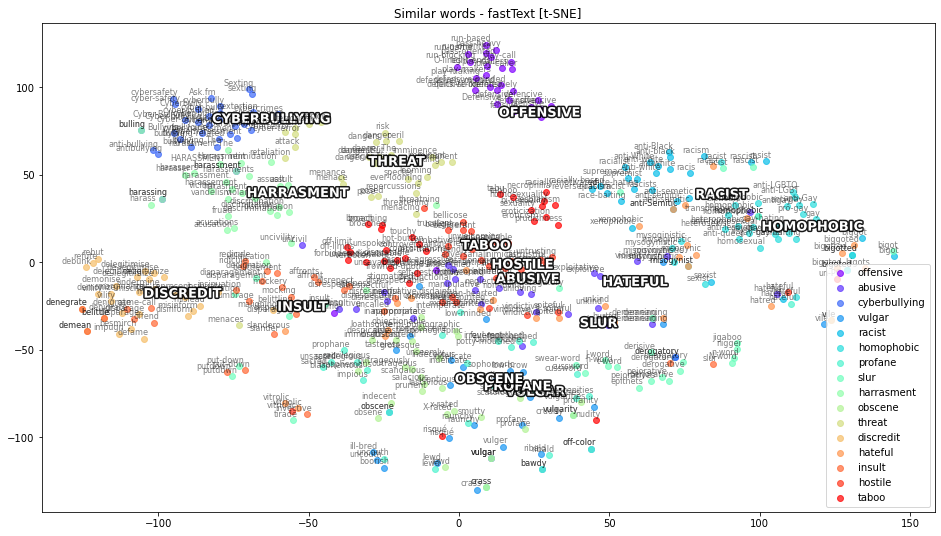

In [29]:
plotTSNE("Similar words - fastText [t-SNE]", word_clusters, embedding_clusters, "SimilarWords - fastText - t-SNE.png")

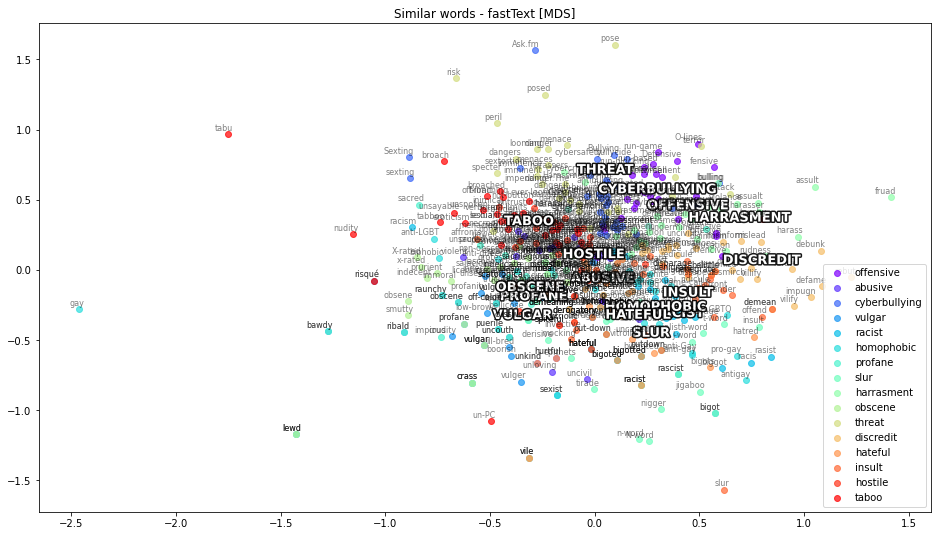

In [30]:
plotMDS("Similar words - fastText [MDS]", word_clusters, embedding_clusters, "SimilarWords - fastText - MDS.png")

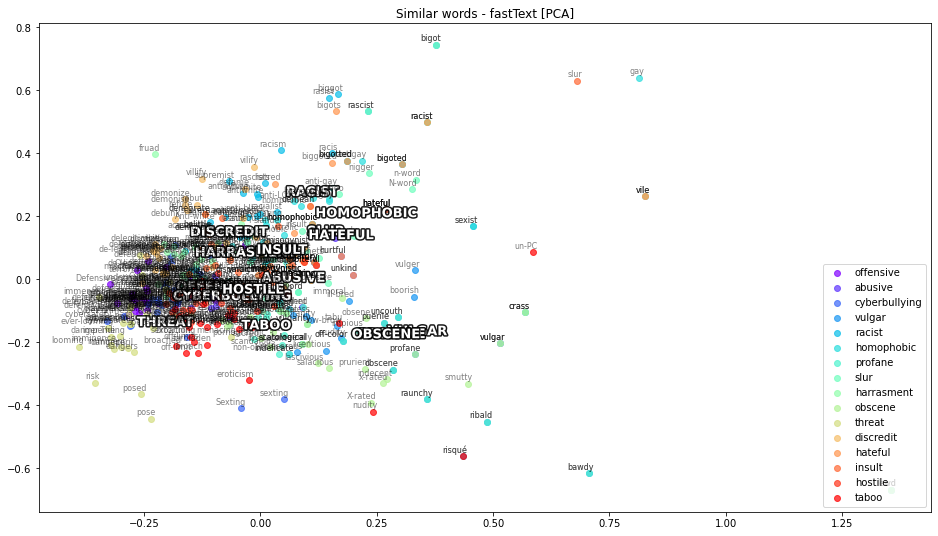

In [31]:
plotPCA("Similar words - fastText [PCA]", word_clusters, embedding_clusters, "SimilarWords - fastText - PCA.png")